## 1. Title, Authors

## 2. Problem Statement & Goals
Using historical price and technical indicators, we aim to build ML models that predict whether the stock price will go up the next day (Future_Up_1d) or not. Our goal is to compare multiple ML approaches—including at least one ensemble and one deep learning model—and evaluate which performs best.

Although price-level prediction is common in applied notebooks, stock prices are non-stationary and heavily scale-dependent. To avoid these issues and to align with a realistic decision-making perspective, this project focuses on predicting next-day price direction as a binary classification task. Directional prediction provides a clearer evaluation framework and is more robust across different stocks.

## 3. Load Dataset(Author: Siyu)
### 3.1. Library import and dataset loading

We begin by loading the raw dataset from the downloaded parquet file(https://huggingface.co/datasets/Adilbai/stock-dataset).

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# adjust the location of the dataset if folder structure changed!
df_raw = pd.read_parquet("../../01_data/train-00000-of-00001.parquet")
df_raw.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,SMA_5,...,Future_Category_1d,Future_Return_5d,Future_Up_5d,Future_Category_5d,Future_Return_10d,Future_Up_10d,Future_Category_10d,Future_Return_20d,Future_Up_20d,Future_Category_20d
0,2020-09-08 00:00:00-04:00,93.113965,93.462744,91.806050,92.174202,1225600,0.0,0.0,A,96.138635,...,3.0,0.054972,1,3.0,0.036578,1,3.0,0.070141,1,3.0
1,2020-09-09 00:00:00-04:00,93.104280,95.400403,92.871764,94.877235,954400,0.0,0.0,A,95.520526,...,2.0,0.020321,1,3.0,-0.010416,0,1.0,0.062670,1,3.0
2,2020-09-10 00:00:00-04:00,95.797603,96.979573,95.177554,95.497269,1933200,0.0,0.0,A,94.580765,...,2.0,0.010449,1,2.0,-0.022623,0,0.0,0.058616,1,3.0
3,2020-09-11 00:00:00-04:00,95.632924,96.514560,94.964430,95.526352,1368600,0.0,0.0,A,94.379250,...,2.0,0.007911,1,2.0,-0.009229,0,1.0,0.074550,1,3.0
4,2020-09-14 00:00:00-04:00,96.621112,97.105525,95.884801,96.320770,1207700,0.0,0.0,A,94.879166,...,2.0,-0.012975,0,1.0,0.000905,1,2.0,0.062363,1,3.0


### 3.2. Dataset Overview 

We inspect the structure of the dataset, including the number of rows and columns, data types, and memory usage.
This step helps verify that the dataset was loaded correctly and ensures that all features have appropriate data types for further processing.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620095 entries, 0 to 620094
Data columns (total 73 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 620095 non-null  object 
 1   Open                 620095 non-null  float64
 2   High                 620095 non-null  float64
 3   Low                  620095 non-null  float64
 4   Close                620095 non-null  float64
 5   Volume               620095 non-null  int64  
 6   Dividends            620095 non-null  float64
 7   Stock Splits         620095 non-null  float64
 8   Ticker               620095 non-null  object 
 9   SMA_5                620095 non-null  float64
 10  SMA_10               620095 non-null  float64
 11  SMA_20               620095 non-null  float64
 12  SMA_50               620095 non-null  float64
 13  EMA_12               620095 non-null  float64
 14  EMA_26               620095 non-null  float64
 15  MACD             

### 3.3. Check for missing values

In [4]:
df_raw.isnull().sum()

Date                   0
Open                   0
High                   0
Low                    0
Close                  0
                      ..
Future_Up_10d          0
Future_Category_10d    0
Future_Return_20d      0
Future_Up_20d          0
Future_Category_20d    0
Length: 73, dtype: int64

The dataset contains 0 missing values in all 73 columns. No imputations or removals of rows/columns are needed. 

### 3.4. Duplicate row check

In [5]:
df_raw.duplicated().sum()

np.int64(0)

The dataset contains no duplicated rows. We do not need to perform any duplicate row cleaning.

## 4. Dataset Understanding(Author: Siyu)
### 4.1. Dataset overview
The dataset contains historical stock price information for multiple tickers from S&P 500 companies from 2020 - 2025.
Each row represents one ticker on one trading day(Ticker, Date).
### 4.2. Understand data structure

In [6]:
print(df_raw.shape)
print(df_raw.head())
print(df_raw.tail())

(620095, 73)
                        Date       Open       High        Low      Close  \
0  2020-09-08 00:00:00-04:00  93.113965  93.462744  91.806050  92.174202   
1  2020-09-09 00:00:00-04:00  93.104280  95.400403  92.871764  94.877235   
2  2020-09-10 00:00:00-04:00  95.797603  96.979573  95.177554  95.497269   
3  2020-09-11 00:00:00-04:00  95.632924  96.514560  94.964430  95.526352   
4  2020-09-14 00:00:00-04:00  96.621112  97.105525  95.884801  96.320770   

    Volume  Dividends  Stock Splits Ticker      SMA_5  ...  \
0  1225600        0.0           0.0      A  96.138635  ...   
1   954400        0.0           0.0      A  95.520526  ...   
2  1933200        0.0           0.0      A  94.580765  ...   
3  1368600        0.0           0.0      A  94.379250  ...   
4  1207700        0.0           0.0      A  94.879166  ...   

   Future_Category_1d  Future_Return_5d  Future_Up_5d  Future_Category_5d  \
0                 3.0          0.054972             1                 3.0   
1  

The dataset contains 620,095 rows and 73 columns.
This indicates ~620k daily observations across many stocks, which is a large and rich dataset for ML.

### 4.3. Understand Attribute Types

In [7]:
pd.set_option("display.max_rows", None)
print(df_raw.dtypes.sort_values())
df_raw.dtypes.value_counts()

Future_Up_20d            int64
Future_Up_10d            int64
Volume                   int64
Future_Up_5d             int64
Future_Up_1d             int64
RSI_lag_10             float64
RSI_lag_5              float64
RSI_lag_3              float64
RSI_lag_2              float64
RSI_lag_1              float64
Price_Change_lag_10    float64
Price_Change_lag_3     float64
MACD_lag_1             float64
Price_Change_lag_2     float64
Price_Change_lag_1     float64
Volume_lag_10          float64
Volume_lag_5           float64
Volume_lag_3           float64
Price_Change_lag_5     float64
MACD_lag_2             float64
Volume_lag_1           float64
Volume_lag_2           float64
MACD_lag_10            float64
Volatility_lag_1       float64
Volatility_lag_2       float64
Volatility_lag_3       float64
Volatility_lag_5       float64
Volatility_lag_10      float64
Future_Return_1d       float64
Future_Category_1d     float64
Future_Return_5d       float64
Future_Category_5d     float64
Future_R

float64    66
int64       5
object      2
Name: count, dtype: int64

This dataset contains
- 66 float columns
- 5 integer columns
- 2 object columns

### 4.4 Domain understanding of dataset attributes
The dataset includes a broad set of standard technical indicators used in quantitative finance. These engineered features enable machine learning models to learn non-linear and temporal relationships in stock movement prediction.

This aligns well with financial domain knowledge and supports the creation of predictive models.

1. Core market data: 
    - Date — Trading date.
    - Ticker — Stock symbol (e.g., AAPL, MSFT).
    - Open — Opening price of the day.
    - High — Highest price reached during the day.
    - Low — Lowest price reached during the day.
    - Close — Closing price of the day.
    - Volume — Number of shares traded.
    - Dividends — Dividend paid on that day (if any).
    - Stock Splits — Stock split ratio on that date (if any).
    
2. Core market data:
    - SMA_5 = short-term trend
    - SMA_20 = medium-term trend
    - SMA_50 = longer-term trend
    - EMA_12, EMA_26 — Exponentially weighted moving averages that give more weight to recent prices.

3. MACD(Momentum Indicators)- measure momentum by comparing short vs long EMAs.
    - MACD — Difference between EMA_12 and EMA_26; indicates trend momentum.
    - MACD_Signal — 9-day EMA of MACD; used as a trigger signal.
    - MACD_Histogram — MACD minus Signal; shows strength of momentum.
    
4. RSI – Relative Strength Index
    - Momentum and reversal indicator.
    - RSI — Oscillates between 0–100.
        - 70 = overbought
        - <30 = oversold
5. Bollinger Bands (Volatility Indicators) - Bollinger Bands measure volatility by placing upper and lower lines two standard deviations away from a moving average, helping quantify whether prices are relatively high, low, or in a squeeze/breakout condition.
    - BB_Middle — Middle band (typically a 20-day SMA).
    - BB_Upper — Middle band + 2 standard deviations.
    - BB_Lower — Middle band – 2 standard deviations.
    - BB_Width — Distance between upper and lower bands (volatility measure).
    - BB_Position — Relative position of price inside the band (0 = lower, 1 = upper).

6. Volatility & Price Ratio Features
    - Volatility — Daily volatility measure (e.g., ATR-based or percent change).
    - Price_Change — 1-day percentage change.
    - Price_Change_5d — 5-day percentage change.
    - High_Low_Ratio — High ÷ Low; intraday volatility.
    - Open_Close_Ratio — Open ÷ Close; sentiment indicator.
    - Volume_SMA — Moving average of volume.
    - Volume_Ratio — Current volume ÷ average volume.
  
7. Lag Features (Past Outcomes): Lagged values allow models to learn sequential patterns without deep learning. These features help ML models incorporate past patterns into predictions.
    - Close_lag_1, Close_lag_2, … Close_lag_10 — Closing price from previous N days.
    - Volume_lag_1, Volume_lag_2, … — Lagged volume.
    - Price_Change_lag_1, … — Lagged returns.
    - RSI_lag_1, MACD_lag_, Volatility_lag_ — Lagged indicator values.

8. Future Targets (Supervised Labels): These are the prediction targets provided in the dataset. These target variables enable both regression and classification tasks.
    - Future_Return_1d, 5d, 10d, 20d — Forward returns over N days.
    - Future_Up_1d, 5d, 10d, 20d — Binary labels: 1 if the future close is higher than today, else 0.
    - Future_Category_1d, 5d, 10d, 20d — Multi-class direction categories.       - 

### 4.5. Target variable understanding

In [8]:
df_raw["Future_Up_1d"].value_counts(normalize=True)

Future_Up_1d
1    0.518596
0    0.481404
Name: proportion, dtype: float64

The target variable 'Future_up_1d' indicates whether the next day's closing price is higher(1) or lower(0) compared to today. 
The class distribution is approximately balanced(51.9% higher, 48.1% lower). 

### 4.6. Understanding Ticker

In [9]:
print(df_raw["Ticker"].nunique())
print(sorted(df_raw["Ticker"].unique()))
tickers_A = df_raw[df_raw["Ticker"].str.endswith("-A")]["Ticker"].unique()
print(sorted(tickers_A))
tickers_B = df_raw[df_raw["Ticker"].str.endswith("-B")]["Ticker"].unique()
print(sorted(tickers_B))

503
['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APO', 'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BALL', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK-B', 'BRO', 'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COIN', 'COO', 'COP', 'COR', 'COST', 'CPAY', 'CPB', 'CPRT', 'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH', 'CTVA', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DASH', 'DAY', 'DD', 'DE', 'DECK', 'DELL', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR',

The Ticker column represents the standardized stock ticker symbols used to identify publicly traded companies in the financial markets. Each ticker is a short alphanumeric code uniquely assigned to a specific company (e.g., AAPL for Apple, MSFT for Microsoft). 

In this dataset, there are 503 unique tickers, meaning the data contains price and market information for 503 different companies. 

Some tickers include suffixes such as “-A” or “-B”, which typically denote multiple share classes issued by the same company. For example, BF-B and BRK-B indicate Class B shares for Brown-Forman and Berkshire Hathaway, respectively. 

These share classes often differ in voting rights, liquidity, or price levels while still representing the same underlying firm. Identifying and understanding tickers—and their variations—is essential for grouping, filtering, and performing company-level analysis within the dataset. 

It should be considered in following data processing, that this dataset contains multiple tickers for the same company(A & B indicates shares with different voting rights):
- goog vs googl
- foxa vs fox
- nwsa vs nws

### 4.7. Basic Descriptive statistics

In [10]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,620095.0,1.706274e+02,3.487984e+02,2.216000,5.408444e+01,1.007565e+02,1.937515e+02,9.914170e+03
High,620095.0,1.726560e+02,3.529315e+02,2.318000,5.475288e+01,1.020246e+02,1.960136e+02,9.964770e+03
Low,620095.0,1.685721e+02,3.447943e+02,2.195000,5.341888e+01,9.950196e+01,1.914322e+02,9.794000e+03
Close,620095.0,1.706449e+02,3.488749e+02,2.225000,5.408973e+01,1.008029e+02,1.937215e+02,9.924400e+03
Volume,620095.0,6.096960e+06,2.343659e+07,0.000000,1.006000e+06,2.122600e+06,4.888700e+06,1.543911e+09
Dividends,620095.0,8.466105e-03,1.502363e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,7.500000e+01
Stock Splits,620095.0,5.090107e-04,8.840941e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01
SMA_5,620095.0,1.704685e+02,3.483895e+02,2.282600,5.406469e+01,1.006932e+02,1.936241e+02,9.814860e+03
SMA_10,620095.0,1.702525e+02,3.478159e+02,2.405400,5.400102e+01,1.005650e+02,1.934740e+02,9.693651e+03
SMA_20,620095.0,1.705074e+02,3.483468e+02,2.571350,5.412393e+01,1.007083e+02,1.938349e+02,9.672676e+03


The descriptive statistics obtained provide several important insights into the dataset:

- Price features behave realistically.  
  The `Open`, `High`, `Low`, and `Close` columns show consistent and plausible ranges. No negative values occur, and the typical relationships between prices (High ≥ Open/Close ≥ Low) hold. This suggests the price data is syntactically and semantically accurate.

- Technical indicators fall within expected financial ranges.  
  SMA and EMA values follow trends consistent with moving-average calculations.  
  RSI stays between 0 and 100, MACD-related features oscillate around zero, and Bollinger Bands maintain their expected ordering (Upper > Middle > Lower).  
  This confirms correct computation of technical indicators.

- Return and volatility features show reasonable behaviour.  
  Daily returns average close to zero, volatility is strictly positive, and multi-day returns increase in magnitude as the window length grows (1d < 5d < 10d).  
  No extreme spikes or unrealistic values appear.

- Volume-based features exhibit large variance but remain valid.  
  Trading volume naturally varies widely across companies of different sizes. No negative values occur, and volume ratios/SMAs behave as expected.

- Lag features mirror the properties of their original variables.  
  Lagged prices, lagged volumes, and lagged indicators show similar ranges and distributions to their base features, confirming correct construction of lag variables.

- All features show meaningful variance.  
  There are no constant or near-constant columns, and no indicators appear collapsed or degenerate.  
  This suggests that the dataset is informative and suitable for machine learning.

- Feature scaling will be required.  
  Numerical features operate on very different scales (prices in the hundreds, RSI in 0–100, MACD in decimals, returns near zero).  
  Standardization or normalization is necessary before training distance-based models or neural networks.

Overall conclusion:  
The descriptive statistics confirm that the dataset is clean, realistic, and well-structured. It is highly suitable for exploratory data analysis and for builine-learning model development.


### 4.8. Suitability of data for ML
The dataset is highly suitable for supervised machine learning because:

It contains labeled target variables for 1-day, 5-day, 10-day, and 20-day horizons.

All features are numeric, facilitating model training.

Indicators are standard in financial forecasting and provide meaningful predictive signals.

The dataset is large (620k rows), enabling models to generalize better.

Based on this analysis, we select **Future_Up_1d** as our prediction target for a binary classification task.

### 4.9 Project Scope definition
Although the dataset contains over 500 companies, modeling all of them in the same project would introduce substantial heterogeneity in liquidity, volatility, and trading behavior. Therefore, the modeling scope is defined at this stage.

We select a representative subset of companies based on objective liquidity criteria. Specifically, companies are ranked by their average dollar trading volume(calculated as closing price multiplied by trading volume) and filtered by minimum data availability. The top 10 companies by average dollar volume are selected and used consistently throughout all subsequent data cleaning, exploratory analysis, and modeling steps.

This approach ensures robust price formation, reduces noise from illiquid stocks, and keeps the analysis tractable while maintaining generalizability.

In [11]:
# Step 1: Compute long-term average dollar volumedf_raw["DollarVolume"] = df_raw["Close"] * df_raw["Volume"]

# Work on a copy to avoid side effects
df = df_raw.copy()

# Dollar Volume = Close price × traded volume
df["DollarVolume"] = df["Close"] * df["Volume"]

company_stats = (
    df.groupby("Ticker")
    .agg(n_obs=("Date", "count"), avg_dollar_volume=("DollarVolume", "mean"))
    .sort_values("avg_dollar_volume", ascending=False)
)

company_stats = company_stats[company_stats["n_obs"] >= 500]

company_stats.head()

,n_obs,avg_dollar_volume
Ticker,,
TSLA,1245,2.486476e+10
NVDA,1245,1.831599e+10
AAPL,1245,1.234558e+10
AMZN,1245,9.443931e+09
MSFT,1245,8.035081e+09


In [12]:
# Step 2: Select top 10 companies by liquidity
selected_tickers = company_stats.head(10).index.tolist()
selected_tickers

['TSLA',
 'NVDA',
 'AAPL',
 'AMZN',
 'MSFT',
 'AMD',
 'META',
 'GOOGL',
 'GOOG',
 'NFLX']

In [13]:
# Step 3: Freeze scope
df_selected = df[df["Ticker"].isin(selected_tickers)].copy()
df_selected.shape

(12450, 74)

## 5. Data Cleaning & Preparation
### 5.1 Structural integrity checks

In [14]:
# Step 1: Duplicate observations, making sure each row represent one ticker on the trading day
df_selected.duplicated(subset=["Date", "Ticker"]).sum()

np.int64(0)

In [15]:
# Step 2: OHLC logical consistency: make sure prices satisfy market constraints: High >= Open/Close/Low; Low<= Open/Close/High
invalid_ohlc = df_selected[
    (df_selected["High"] < df_selected[["Open", "Close", "Low"]].max(axis=1))
    | (df_selected["Low"] > df_selected[["Open", "Close", "High"]].min(axis=1))
]
len(invalid_ohlc)

0

There's 0 invalid OHLC, this ensures syntactic accuracy of the price data. 

### 5.2 Check Missing values
We already confirmed in step 3.3, there's no missing value in this dataset. 

### 5.3 Outlier
Financial time series naturally contain extreme observations(earnings, news shocks). Therefore, outliers should not be removed as they are real events, and removing them may bias the distribution of price changes. 

In this dataset, the most relevant columns for detecting outliers are: Price_Change(daily price change), Price_Change_5d(5day price change), Volatility(rolling volatility feature). Here, we'd like to inspect them just for information. 

In [16]:
df_selected[["Price_Change", "Price_Change_5d", "Volatility"]].describe(
    percentiles=[0.01, 0.05, 0.95, 0.99]
)

,Price_Change,Price_Change_5d,Volatility
count,12450.000000,12450.000000,12450.000000
mean,0.001220,0.005939,8.652217
std,0.026943,0.058939,9.292566
min,-0.351166,-0.430883,0.076337
1%,-0.070068,-0.139901,0.505826
5%,-0.039321,-0.083503,1.294758
50%,0.001066,0.005202,5.846611
95%,0.041617,0.100788,26.190683
99%,0.077443,0.174835,42.983465
max,0.243696,0.441278,125.690858


### 5.4: Temporal odering and data types(model-readiness)
Here we check for time ordering correctness to ensure data integrity

Step 1: Parse date column and sort
Date is stored as a string in the dataset in Huggingface. Here, we convert it to datetime and sort it by Ticker, then Date to ensure correct temporal ordering for time series modeling. 

In [17]:
df_clean = df_selected.copy()

df_clean["Date"] = pd.to_datetime(df_clean["Date"], errors="coerce")
df_clean = df_clean.sort_values(["Ticker", "Date"]).reset_index(drop=True)

df_clean["Date"].isna().sum()

/tmp/ipykernel_5234/3884062401.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_clean["Date"] = pd.to_datetime(df_clean["Date"], errors="coerce")


np.int64(0)

As a result, the Date column was converted to datetime format. No invalid or missing timestamps were detected (0 null values), confirming complete and consistent temporal information.

### 5.5: Leakage Sanity Check
As the chosen feature is Future_Up_1d, we should confirm that the predictors do not include future information. 

Thus, we exclude all future-horizon targets:

In [18]:
future_cols = [c for c in df_clean.columns if c.startswith("Future_")]
target_col = "Future_Up_1d"
# remove future columns from feature columns
feature_cols = [c for c in df_clean.columns if c not in future_cols + [target_col]]
# define non-predictive columns
non_predictive = ["Date", "Ticker"]
feature_cols = [c for c in feature_cols if c not in non_predictive]
# quick sanity check
feature_cols[:10], len(feature_cols)

(['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'Dividends',
  'Stock Splits',
  'SMA_5',
  'SMA_10',
  'SMA_20'],
 60)

To prevent look-ahead bias, all future-horizon target variables (Future_*) were excluded from the feature set. 
The target variable Future_Up_1d was defined explicitly, and the remaining columns were used as predictors.
The non-predictive columns such as Date and Ticker are removed from feature columns as well. 

## 6. Exploratory Data Analysis
### 6.1: Baseline Benchmark
Before training ML models, we computer a naive baseline based on the majority class

In [19]:
baseline_accuracy = df_clean["Future_Up_1d"].value_counts(normalize=True).max()
baseline_accuracy

0.5227309236947791

The majority-class baseline accuracy is approximately 52.3%, indicating that the dataset is close to balanced and that predicting next-day price direction is a challenging task. All machine learning models are evaluated relative to this benchmark.

### 6.2: Distribution of key features
First we look at Relative Strength Index(RSI): It captures short-term momentum, by visualizing it, we can verify that momentum signals behave as expected and may contain weak predictive information. 

In [20]:
df_clean["RSI"].describe()

count    12450.000000
mean        53.490879
std         16.997527
min          2.540857
25%         41.198829
50%         53.472653
75%         66.151781
max        100.000000
Name: RSI, dtype: float64

<Axes: >

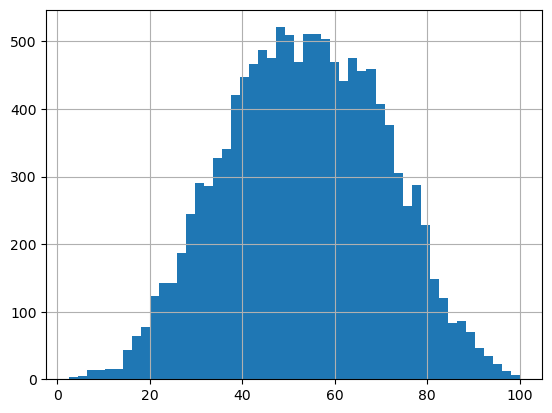

In [21]:
df_clean["RSI"].hist(bins=50)

The RSI distribution is bounded within its theoretical range of 0 to 100 and is centered around 50, indicating predominantly neutral momentum conditions. The distribution is unimodal and symmetric, with most observations falling within the typical 30–70 range. This confirms correct feature construction and suggests that RSI may provide weak but informative signals for short-term price direction when combined with other indicators.

In [22]:
df_clean["MACD"].describe()

count    12450.000000
mean         1.211205
std          7.574520
min        -59.233806
25%         -1.576983
50%          0.810314
75%          3.524927
max         54.652794
Name: MACD, dtype: float64

<Axes: >

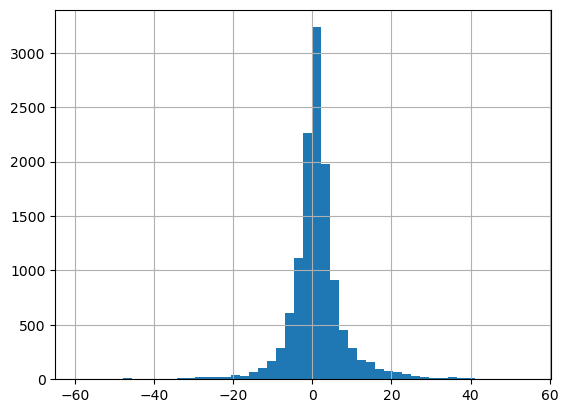

In [23]:
df_clean["MACD"].hist(bins=50)

The MACD distribution is centered close to zero, with symmetric positive and negative values, indicating balanced upward and downward trend periods. Extreme MACD values occur infrequently and correspond to strong trend regimes. This confirms correct feature construction and supports the use of MACD as a trend-based predictor in the classification task.

In [24]:
df_clean["Volatility"].describe()

count    12450.000000
mean         8.652217
std          9.292566
min          0.076337
25%          3.516463
50%          5.846611
75%         10.333452
max        125.690858
Name: Volatility, dtype: float64

<Axes: >

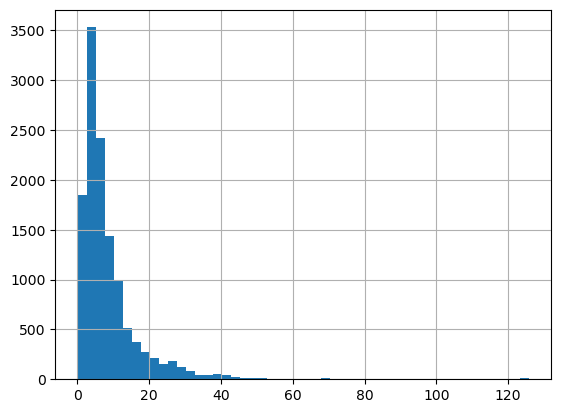

In [25]:
df_clean["Volatility"].hist(bins=50)

The volatility distribution is strictly positive and strongly right-skewed, reflecting occasional high-volatility market regimes. These extreme observations are economically meaningful and are therefore retained. Volatility captures market uncertainty and may influence the predictability of short-term price movements.

### 6.3 Feature Target Relationships
We examines how selected technical indicators(RSI, MACD, Volatility) differ depending on whether the stock price increases or decreases the following day.

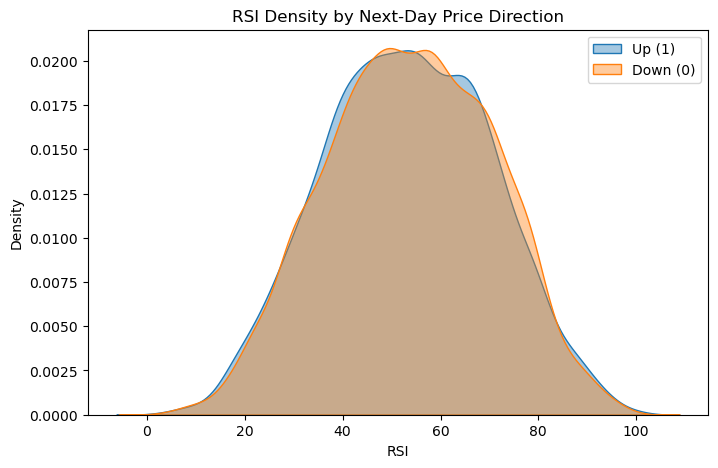

In [30]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 1]["RSI"], label="Up (1)", fill=True, alpha=0.4
)
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 0]["RSI"],
    label="Down (0)",
    fill=True,
    alpha=0.4,
)
plt.title("RSI Density by Next-Day Price Direction")
plt.xlabel("RSI")
plt.ylabel("Density")
plt.legend()
plt.show()

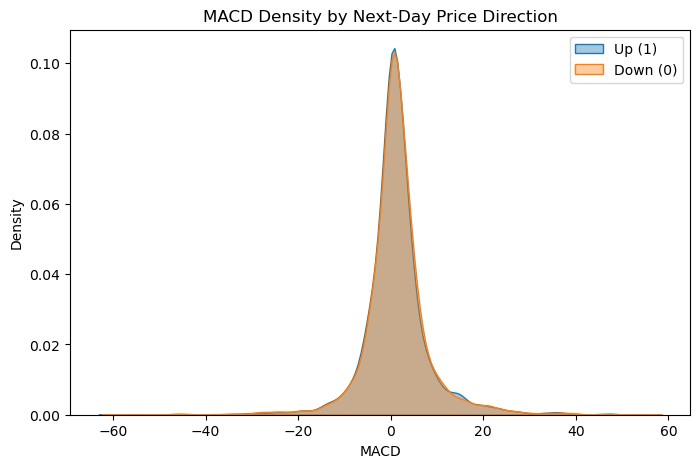

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 1]["MACD"],
    label="Up (1)",
    fill=True,
    alpha=0.4,
)
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 0]["MACD"],
    label="Down (0)",
    fill=True,
    alpha=0.4,
)

plt.title("MACD Density by Next-Day Price Direction")
plt.xlabel("MACD")
plt.ylabel("Density")
plt.legend()
plt.show()

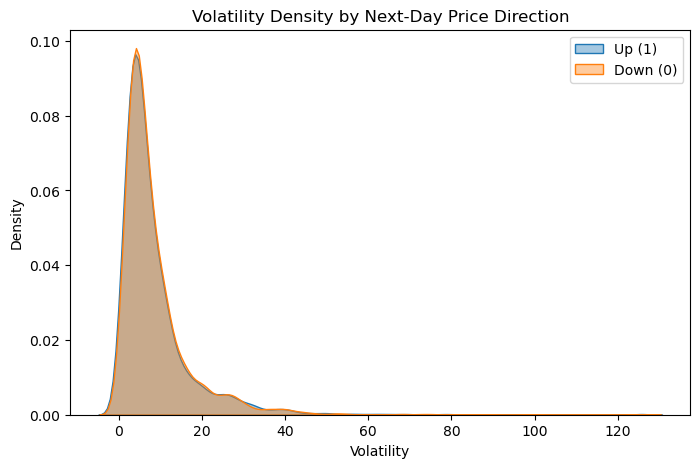

In [33]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 1]["Volatility"],
    label="Up (1)",
    fill=True,
    alpha=0.4,
)
sns.kdeplot(
    df_clean[df_clean["Future_Up_1d"] == 0]["Volatility"],
    label="Down (0)",
    fill=True,
    alpha=0.4,
)
plt.title("Volatility Density by Next-Day Price Direction")
plt.xlabel("Volatility")
plt.ylabel("Density")
plt.legend()
plt.show()

The overlaid density plots for RSI, MACD, and Volatility reveal substantial overlap between upward and downward next-day price movements. This indicates that no single technical indicator provides strong predictive power in isolation. Such behavior is typical for short-horizon financial data, where signal-to-noise ratios are low and simple rule-based strategies are ineffective. However, small and consistent differences in distribution shape suggest the presence of weak signals that may be exploitable when multiple indicators are combined. These findings motivate the use of machine learning models to capture non-linear interactions among features rather than relying on individual indicators.

### 6.4: Multivariate Feature Relationship Exploration
To examine whether combinations of technical indicators provide stronger discriminatory power than individual features, we visualize the joint distribution of RSI and MACD using a scatterplot colored by the target variable (Future_Up_1d).

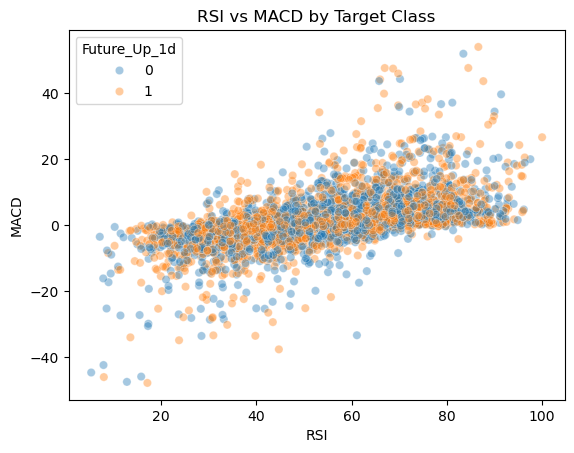

In [34]:
sns.scatterplot(
    data=df_clean.sample(5000, random_state=42),
    x="RSI",
    y="MACD",
    hue="Future_Up_1d",
    alpha=0.4,
)
plt.title("RSI vs MACD by Target Class")
plt.show()

The scatterplot reveals a strong overlap between upward and downward price movements, indicating that the two classes are not linearly separable in the RSI–MACD feature space. While RSI and MACD exhibit a positive correlation, no distinct clusters or decision boundaries emerge that would allow for simple rule-based classification.

This suggests that next-day price direction is driven by complex, nonlinear interactions between features rather than by single indicators or simple linear combinations. As a result, more expressive machine learning models are required to capture these relationships.

### 6.5: Correlation Analysis
This section analyzes linear correlations among features and between features and the target variable. The goal is not to identify causal relationships, but to assess feature redundancy, multicollinearity, and whether individual features exhibit linear associations with next-day price direction.

First feature to feature correlation is examined:

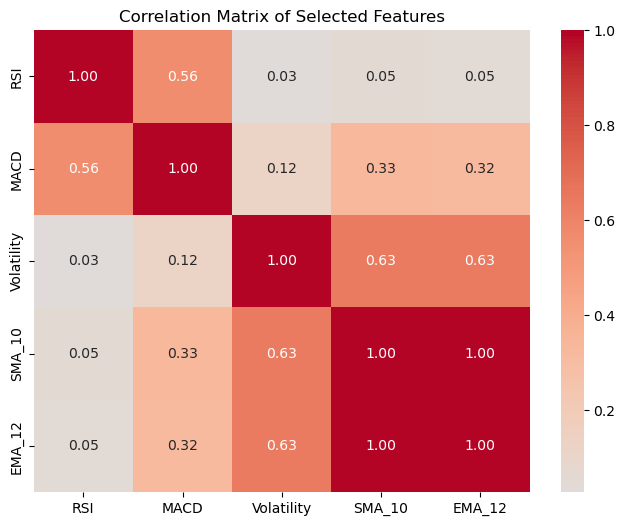

In [35]:
selected_features = ["RSI", "MACD", "Volatility", "SMA_10", "EMA_12"]

corr_matrix = df_clean[selected_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Selected Features")
plt.show()

The correlation matrix reveals moderate correlation between RSI and MACD, reflecting their shared focus on momentum and trend dynamics. Moving-average-based indicators (SMA and EMA) exhibit near-perfect correlation, indicating substantial redundancy due to their similar construction. Volatility shows strong correlation with moving averages, consistent with volatility clustering during trending market regimes, but remains largely uncorrelated with RSI. Overall, the results suggest the presence of multicollinearity among related indicators while confirming that different feature groups capture complementary aspects of market behavior.

Next feature to target correlation is examined

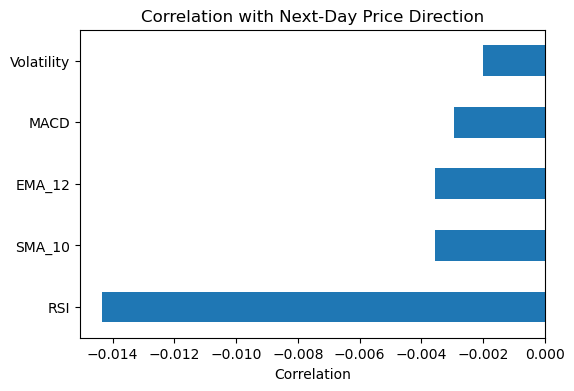

In [36]:
target_corr = df_clean[selected_features + ["Future_Up_1d"]].corr()["Future_Up_1d"]

target_corr.drop("Future_Up_1d").sort_values().plot(kind="barh", figsize=(6, 4))
plt.title("Correlation with Next-Day Price Direction")
plt.xlabel("Correlation")
plt.show()

Linear correlations between individual features and the next-day price direction are close to zero, indicating that no single indicator explains the target through a linear relationship. RSI exhibits a very small negative correlation, suggesting weak mean-reversion effects, while MACD, moving averages, and volatility show negligible correlation. These results are consistent with previous visual analyses and highlight the limitations of linear correlation measures for capturing short-term price dynamics.

### 6.6 Conclusion
The EDA shows that next-day stock price direction is difficult to predict, with a baseline accuracy of approximately 52%. All technical indicators are well-constructed and exhibit economically plausible distributions, confirming the quality and suitability of the dataset.

Feature–target analyses reveal substantial overlap between upward and downward price movements across all indicators and their combinations, indicating that no single feature provides strong predictive power in isolation. Correlation analysis further confirms weak linear relationships with the target variable and highlights multicollinearity among related indicators, particularly moving averages.

Overall, the EDA suggests that predictive information is weak and distributed across multiple features. This motivates the use of supervised machine learning models capable of handling multicollinearity and capturing nonlinear interactions, rather than relying on individual indicators or linear relationships.

Proposed Models:
1. Logistic Regression
2. k Nearest Neighbors
3. Random Forest(Ensemble)
4. Feed-Forward ANN(DL)

## 7. Data Preprocessing for ML/DL models

## 8 Try RF directly

In [37]:
Y = df_raw[["Future_Up_1d"]]
X = df_raw[["Open", "Volatility_lag_10"]]